In [ ]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

In [ ]:
# !conda install -c anaconda seaborn -y

In [3]:
import sys
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
# %matplotlib widget

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.manifold import TSNE

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [4]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/emb_viz' # needs to change...

In [5]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [6]:
emb_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [7]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

In [8]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

## Get Noise data

In [9]:
import pickle
def load_event(event_path):
    with open(event_path, 'rb') as f:
        hits, truth = pickle.load(f)
    return hits, truth

In [10]:
noise_data = []
# evtid = np.random.randint(1000,1009)
evtid=1005
print(evtid)
for n in noise_keep:
    data = torch.load(f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{n}/feature_store/{evtid}')
    noise_data.append(data)

1005


In [11]:
noise_data

[Data(cell_data=[92218, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[92218], layerless_true_edges=[2, 109839], layers=[92218], pid=[92218], x=[92218, 3]),
 Data(cell_data=[95779, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[95779], layerless_true_edges=[2, 356699], layers=[95779], pid=[95779], x=[95779, 3]),
 Data(cell_data=[99340, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[99340], layerless_true_edges=[2, 1123614], layers=[99340], pid=[99340], x=[99340, 3]),
 Data(cell_data=[102901, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[102901], layerless_true_edges=[2, 2390179], layers=[102901], pid=[102901], x=[102901, 3]),
 Data(cell_data=[106462, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[106462], layerless_true_edges=[2, 4101835], layers=[1

In [12]:
noise_data[0]

Data(cell_data=[92218, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001005", hid=[92218], layerless_true_edges=[2, 109839], layers=[92218], pid=[92218], x=[92218, 3])

In [13]:
n = []
nn = []
for d in noise_data:
    arr = d['pid']
    n_count = np.count_nonzero(arr==0)
    not_n = np.count_nonzero(arr)
    n.append(n_count)
    nn.append(not_n)

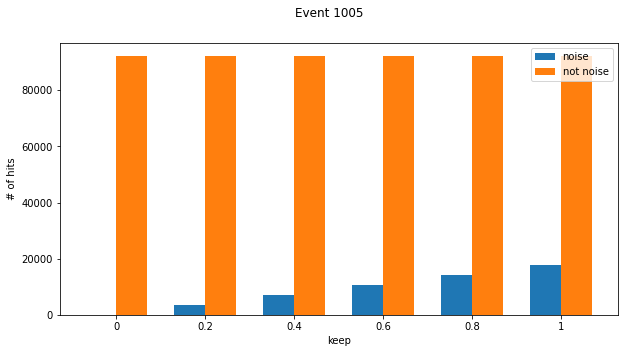

In [14]:
x = np.arange(len(noise_keep))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, n, width, label='noise')
rects2 = ax.bar(x + width/2, nn, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('keep')
ax.set_xticks(x)
labels = noise_keep
ax.set_xticklabels(labels)
fig.suptitle(f'Event {evtid}')
ax.legend()

## Select 10 tracks

In [15]:
total_un = noise_data[5]['pid'].unique()
total_unq = []
for u in total_un:
    if (u!=0):
        total_unq.append(u)

In [16]:
unq_pid = np.random.choice(total_unq, 10)
unq_pid

array([193656089646989312, 909735233627095040, 108099653932687362,
       630504703746113536, 702567726622703616, 747601523873153024,
       238691879762264064,  45036339871088640, 432352917211578368,
        90077833702932480])

In [17]:
trk_hits = np.where(np.isin(noise_data[5]['pid'].detach().numpy(),unq_pid))
trk_idx = trk_hits[0]
trk_idx = trk_idx.flatten()
trk_idx

array([  2762,   2808,   3034,   3780,   4744,   4777,   5298,   7780,
         7810,  10852,  11683,  13035,  13309,  13343,  13371,  13868,
        14155,  17260,  17523,  19651,  19690,  20638,  20766,  22127,
        24943,  25106,  27425,  27549,  27595,  27872,  28890,  29139,
        30486,  32855,  34215,  34793,  34925,  34986,  35352,  38055,
        38644,  40773,  43666,  43681,  46212,  47583,  47624,  47751,
        52916,  53071,  55308,  55625,  55704,  56766,  56977,  57593,
        57736,  58447,  62241,  62417,  65194,  65219,  65437,  67136,
        67691,  67783,  68114,  71482,  75478,  76376,  76891,  76989,
        79227,  80422,  80654,  80866,  81684,  83703,  85543,  86070,
        89522,  89551,  90177,  90456,  90710,  90740,  91616,  91970,
        94540,  95012,  96552,  97083,  98522,  99019, 100429, 100879,
       101906, 102573, 104007, 104024, 105316, 105903, 108533])

In [18]:
noise_data[5]['pid'][trk_idx].unique() 

tensor([ 45036339871088640,  90077833702932480, 108099653932687362,
        193656089646989312, 238691879762264064, 432352917211578368,
        630504703746113536, 702567726622703616, 747601523873153024,
        909735233627095040])

In [19]:
pids = noise_data[5]['pid'][trk_idx].type(torch.FloatTensor).flatten().T
pids

tensor([1.9366e+17, 9.0078e+16, 1.9366e+17, 9.0974e+17, 4.3235e+17, 7.4760e+17,
        6.3050e+17, 9.0078e+16, 1.9366e+17, 9.0974e+17, 2.3869e+17, 7.4760e+17,
        1.9366e+17, 9.0078e+16, 4.3235e+17, 6.3050e+17, 6.3050e+17, 7.0257e+17,
        9.0974e+17, 1.9366e+17, 9.0078e+16, 7.4760e+17, 4.3235e+17, 6.3050e+17,
        9.0974e+17, 2.3869e+17, 1.9366e+17, 1.0810e+17, 9.0078e+16, 1.9366e+17,
        7.4760e+17, 4.3235e+17, 6.3050e+17, 7.0257e+17, 9.0974e+17, 1.9366e+17,
        9.0078e+16, 2.3869e+17, 2.3869e+17, 7.4760e+17, 4.3235e+17, 6.3050e+17,
        2.3869e+17, 7.0257e+17, 9.0974e+17, 1.9366e+17, 9.0078e+16, 1.9366e+17,
        7.0257e+17, 2.3869e+17, 7.4760e+17, 1.0810e+17, 7.4760e+17, 4.3235e+17,
        4.5036e+16, 4.5036e+16, 4.5036e+16, 6.3050e+17, 7.0257e+17, 6.3050e+17,
        1.9366e+17, 9.0078e+16, 1.9366e+17, 4.5036e+16, 4.5036e+16, 4.5036e+16,
        9.0974e+17, 7.0257e+17, 7.4760e+17, 4.5036e+16, 4.5036e+16, 4.5036e+16,
        2.3869e+17, 9.0078e+16, 1.9366e+

In [20]:
hids = noise_data[5]['hid'][trk_idx].type(torch.FloatTensor).flatten().T
hids

tensor([1.7676e+04, 1.7790e+04, 1.7811e+04, 2.0323e+04, 1.9348e+04, 1.9044e+04,
        1.7192e+04, 2.5852e+04, 2.5795e+04, 2.8043e+04, 2.1878e+04, 2.5525e+04,
        3.1845e+04, 3.1861e+04, 2.7694e+04, 2.4830e+04, 2.4852e+04, 2.2062e+04,
        3.4532e+04, 3.7333e+04, 3.7348e+04, 3.1206e+04, 3.4792e+04, 3.1219e+04,
        4.0389e+04, 2.9505e+04, 6.5598e+04, 9.3167e+04, 6.5614e+04, 6.5588e+04,
        3.6847e+04, 4.0605e+04, 3.6485e+04, 2.9810e+04, 6.8472e+04, 7.1769e+04,
        7.1787e+04, 3.5900e+04, 3.5902e+04, 6.4766e+04, 6.8683e+04, 6.4775e+04,
        4.3808e+04, 4.1743e+04, 7.4915e+04, 7.7289e+04, 7.7596e+04, 7.7579e+04,
        4.4512e+04, 4.6451e+04, 7.0786e+04, 9.4356e+04, 7.0781e+04, 7.5366e+04,
        7.1660e+03, 7.2300e+03, 7.1200e+03, 7.0803e+04, 4.7101e+04, 7.0794e+04,
        8.2960e+04, 8.2976e+04, 8.2958e+04, 4.8840e+03, 4.9410e+03, 4.8430e+03,
        8.1513e+04, 4.9568e+04, 7.6495e+04, 2.9590e+03, 3.0060e+03, 2.9220e+03,
        6.9921e+04, 9.8116e+04, 9.8094e+

In [21]:
ids = torch.stack([hids,pids],axis=1)
ids.shape

torch.Size([103, 2])

In [22]:
hit_data = torch.cat([ids,noise_data[5]['x'][trk_idx]],axis=-1)
hit_data.shape

torch.Size([103, 5])

In [23]:
hit_data[0]

tensor([ 1.7676e+04,  1.9366e+17,  3.1971e-02, -5.0267e-01, -3.1695e-02])

In [24]:
x_coord = hit_data[:,2]
y_coord = hit_data[:,3]

In [25]:
np.where(hit_data[:,1] == float(unq_pid[0]))

(array([ 0,  2,  8, 12, 19, 26, 29, 35, 45, 47, 60, 62, 74, 75, 84, 85]),)

In [26]:
noise_idx = np.where(noise_data[5]['pid']==0)
nhids = noise_data[5]['hid'][noise_idx].type(torch.FloatTensor).flatten().T
npids = noise_data[5]['pid'][noise_idx].type(torch.FloatTensor).flatten().T
nids = torch.stack([nhids,npids],axis=1)
nhits = torch.cat([nids,noise_data[5]['x'][noise_idx]],axis=-1)
nhits.shape

torch.Size([17805, 5])

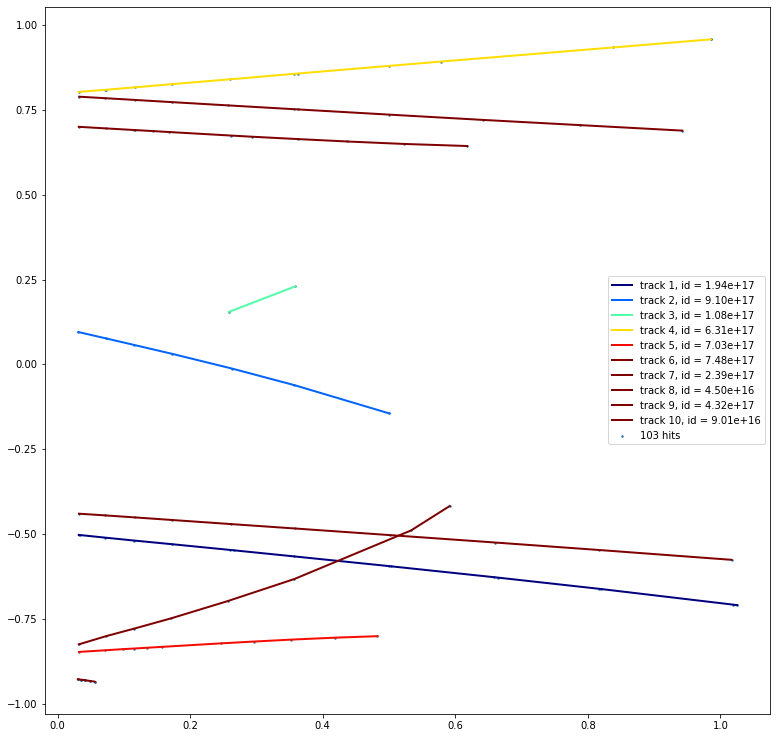

In [27]:
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(x_coord,y_coord,s=2,label=f'{len(x_coord)} hits')
n_ids = np.count_nonzero(hit_data[:,1]==0)
colors = cm.jet(np.linspace(0,10))
for i in range(0,10):
    if (unq_pid[i]==0.0):
        continue;
    else:
        hidx = np.where(hit_data[:,1] == float(unq_pid[i]))
        x = hit_data[hidx][:,2]
        y = hit_data[hidx][:,3]
        ax.plot(x,y,color=colors[i],linewidth=2,label=f'track {i+1}, id = {unq_pid[i]:.2e}')
ax.legend(loc='best')

## Run T-SNE on 10 tracks

In [28]:
tsne_10 = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(hit_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 103 samples in 0.000s...
[t-SNE] Computed neighbors for 103 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 103 / 103
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.315735
[t-SNE] KL divergence after 650 iterations: 0.916496


In [29]:
tsne_10.shape

(103, 2)

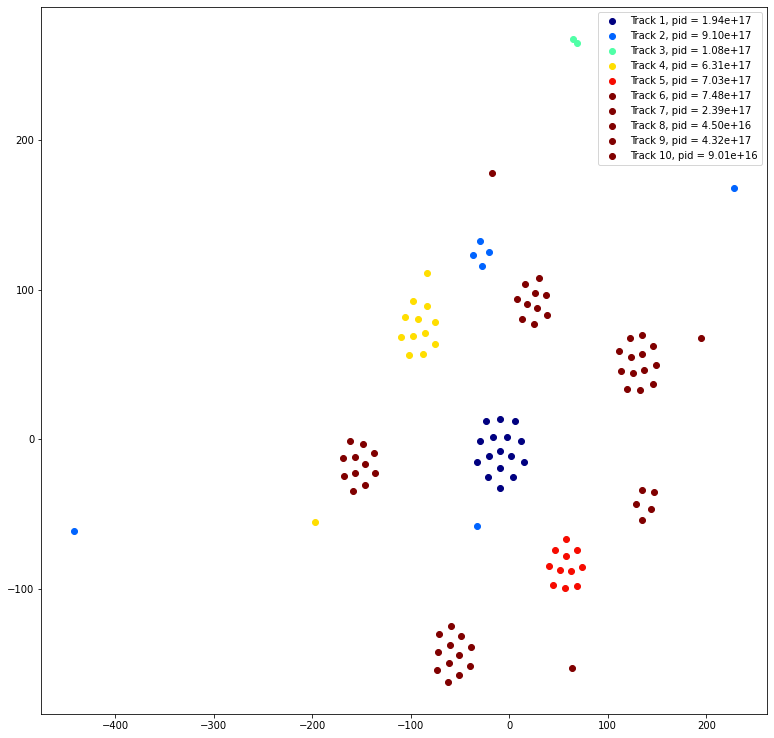

In [30]:
fig3, ax3 = plt.subplots(figsize=(13 ,13))

for j in range(0,10):
    hx = np.where(hit_data[:,1] == float(unq_pid[j]))
    ax3.scatter(tsne_10[hx][:, 0], tsne_10[hx][:, 1], color=colors[j], label=f"Track {j+1}, pid = {unq_pid[j]:.2e}")
ax3.legend(loc='best')

## Run TSNE on 10 Tracks with cell data

In [32]:
hit_all = torch.cat([ids,noise_data[5]['x'][trk_idx],noise_data[5]['cell_data'][trk_idx]],axis=-1)
hit_all.shape

torch.Size([103, 14])

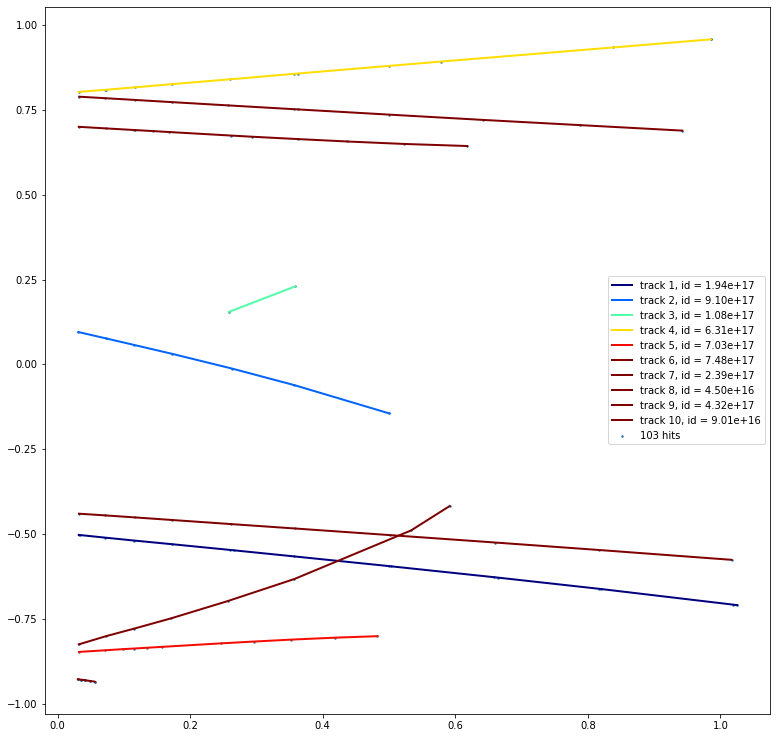

In [33]:
x_coord = hit_data[:,2]
y_coord = hit_data[:,3]

fig1, ax1 = plt.subplots(figsize=(13,13))
ax1.scatter(x_coord,y_coord,s=2,label=f'{len(x_coord)} hits')
n_ids = np.count_nonzero(hit_all[:,1]==0)
colors = cm.jet(np.linspace(0,11))
for i in range(0,10):
    if (unq_pid[i]==0.0):
        continue;
    else:
        hidx = np.where(hit_all[:,1] == float(unq_pid[i]))
        x = hit_all[hidx][:,2]
        y = hit_all[hidx][:,3]
        ax1.plot(x,y,color=colors[i],linewidth=2,label=f'track {i+1}, id = {unq_pid[i]:.2e}')
ax1.legend(loc='best')

In [34]:
tsne_10_all = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(hit_all)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 103 samples in 0.000s...
[t-SNE] Computed neighbors for 103 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 103 / 103
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.656410
[t-SNE] KL divergence after 900 iterations: 0.211178


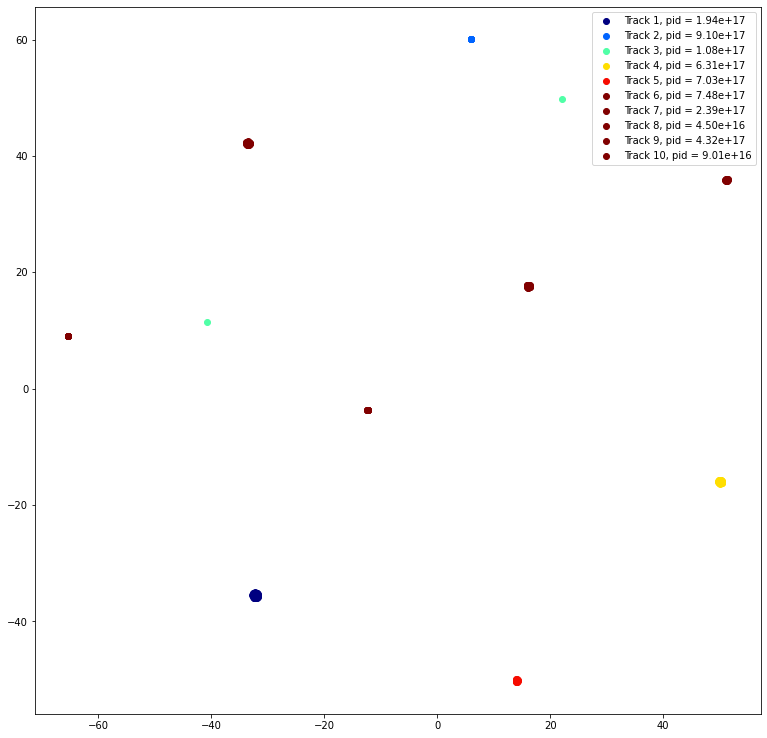

In [35]:
fig4, ax4 = plt.subplots(figsize=(13 ,13))

for j in range(0,10):
    hx = np.where(hit_all[:,1] == float(unq_pid[j]))
    ax4.scatter(tsne_10_all[hx][:, 0], tsne_10_all[hx][:, 1], color=colors[j], label=f"Track {j+1}, pid = {unq_pid[j]:.2e}")
ax4.legend(loc='best')

## Hyperparameter Tuning 